In [ ]:
%pylab inline


In [506]:
%pylab inline
import pandas as pd
# Let's try to train a fraction of the parameters.
#
import os
homedir = os.path.expanduser('~')

subsample=1
TEST_subsample=1
my_optimizer='sgd'
epochs = 200
checkpointPaths = []
finerRange = list(arange(0,.1,.01))#[1:])
coarseRange = list(arange(.1,1,.3))
absoluteRange = [1,5,10]


#finerRange = finerRange[-2:-1]
#coarseRange=[.1]
absoluteRange = [5,10,1]


#archs = ['densenet_partial','wrn_partial']
archs = ['densenet_partial','wrn_partial','vgg19_bn_partial','alexnet_partial','vgg19_partial',]#,'alexnet_partial']
#archs = ['vgg19_bn_partial']

datasets = ['cifar10','cifar100']
#archs = ['wrn_partial']
if False:
    coarseRange = [.1]
    finerRange = []
    absoluteRange = [1,5]#,10]
kill_fixed_s = [False,True]
pp=0
verbose=False
from itertools import product
fast_schedule = False
status = []


def make_checkpoint_path(ckpt_base_dir,arch,frac,iter_,my_optimizer,subsample,kill_fixed,dataset='cifar10',train_only='train_all'):
    P = arch_to_name_prefix[arch]
    checkpointPath = os.path.join(ckpt_base_dir,
                                  '{f_arch}_{bb}_iter_{iter_}_opt_{opt}_subsample_{s}'.
                                  format(f_arch=P,bb=frac,iter_=iter_,opt=my_optimizer,s=subsample))
    if kill_fixed:
        checkpointPath += '_zero_fixed'
        
    #if frac >= 1:# a fixed integer amount of filters.
    #    checkpointPath += '_I'
    if dataset != 'cifar10':
        checkpointPath += '_C100'
        
    if fast_schedule:
        checkpointPath += '_FS'        
        
    if train_only!='train_all':
        checkpointPath += '_only_{}'.format(train_only)
    return checkpointPath
optimizers = ['sgd']

iters = [0]
#fracs =  finerRange+coarseRange+absoluteRange#coarseRange+absoluteRange
fracs =  coarseRange+absoluteRange+finerRange


resnetWidth = 4
LIMIT_EPOCHS = -1
#LIMIT_EPOCHS = 10
if LIMIT_EPOCHS < 0:
    #fracs = [0.1,1]
    resnetWidth=10
    #archs = ['densenet_partial']
train_onlys = ['conv1','block1','block2','block3','fc','train_all']

all_opts = list(product(fracs,datasets,optimizers,archs,kill_fixed_s,iters,train_onlys))
opts_with_state=[]
ddd = []
dfs = {}

DDD = '/home/amir/checkpoints/cifar10/'
ckpt_base_dir = DDD
arch_to_name_prefix = {'vgg19_partial':'VGG-frac','vgg19_bn_partial':'VGG-BN-frac','alexnet_partial':'ALEXNET-frac','wrn_partial':'WRN-28-{}-frac'.format(resnetWidth),'densenet_partial':'densenet-bc-100-12'}
arch_to_params = {'alexnet_partial':dict(epochs=164,lr_sched='81 122'),
                  'vgg19_partial':dict(epochs=164,lr_sched='81 122'),
                  'vgg19_bn_partial':dict(epochs=164,lr_sched='81 122'),
                  'wrn_partial':dict(epochs=200,lr_sched='60 120 160'),
                  'densenet_partial':dict(epochs=300,lr_sched='150 225')}

PRINT_CMD=True
covered_paths = {}
for frac,dataset,my_optimizer,arch,kill_fixed,iter_,to_train_only in all_opts:
        arch_=arch
        if to_train_only != 'train_all':            
            if not 'wrn' in arch and not 'dense' in arch:            
                continue
            else:                
                frac = -1
                kill_fixed=False
                arch_=arch.replace('_partial','')
        
        n_epochs = arch_to_params[arch]['epochs']
        
        if fast_schedule:
            n_epochs=25
            
        if LIMIT_EPOCHS > 0:
            n_epochs = min(LIMIT_EPOCHS,n_epochs)            
            ckpt_base_dir = DDD + 'LIMIT_EPOCHS'
        if frac > 0 and frac * 16 < 1: # check if there are no non-zero parameters in the first layer.
            #print('continuing on frac:',frac)
            continue
        epochs = n_epochs
        if my_optimizer.lower()=='adam':
            epochs=10
        if frac == 0 and kill_fixed:
            epochs = 1
        
        checkpointPath = make_checkpoint_path(ckpt_base_dir,arch,frac,iter_,my_optimizer,subsample,
                                             kill_fixed,dataset,to_train_only)                        
        
        checkpointPaths.append(checkpointPath)
                        
        if 'wrn' in arch:
            cmd = 'python cifar.py -a {arch} --depth 28 --widen-factor {resnetWidth} --train-batch 128 --drop 0.3 --wd 5e-4 --gamma 0.2 --epochs {epochs}'.\
            format(resnetWidth=resnetWidth,arch=arch_,epochs=epochs)
        elif 'dense' in arch:                
            cmd = 'python cifar.py -a {arch} --depth 100 --growthRate 12 --train-batch 64 --wd 1e-4 --gamma 0.1 --epochs {epochs}'.format(arch=arch_,epochs=epochs)
        elif 'alexnet' in arch:
            cmd = 'python cifar.py -a {arch} --wd 1e-4 --gamma 0.1 --epochs {epochs}'.format(arch=arch_,epochs=epochs) 
        elif 'vgg' in arch:
            cmd = 'python cifar.py -a {arch} --wd 1e-4 --gamma 0.1 --epochs {epochs}'.format(arch=arch_,epochs=epochs) 
        cmd += ' --checkpoint {checkpoint}'
        #cmd += ' --only-layer {retrain_layer}'

        lr=.1 if my_optimizer == 'sgd' else 1e-3
        
        cmd = cmd.format(checkpoint = checkpointPath)#,retrain_layer=retrain_layer)
        cmd += ' --start-epoch 0'
        cmd += ' --learn-bn True'        
        cmd += ' --lr {}'.format(lr)
        cmd += ' --optimizer {}'.format(my_optimizer)
        cmd += ' --subsample {}'.format(subsample)
        cmd += ' --test-subsample {}'.format(TEST_subsample)
        cmd += ' --zero-fixed-part {}'.format(kill_fixed)
        
        
        
        cmd += ' --part {frac}'.format(frac=frac)            
        if fast_schedule:
            cmd += ' --schedule 10 20'
        else:
            cmd += ' --schedule {}'.format(arch_to_params[arch]['lr_sched'])
            

        cmd += ' --dataset {}'.format(dataset)
        
        if frac == -1 and to_train_only != 'train_all':
             cmd += ' --only-layer {}'.format(to_train_only)
        #cmd += ' --schedule 10 20'
                        
        logFilePath = os.path.join(checkpointPath,'log.txt')
        if logFilePath in covered_paths:
            continue
        else:
            covered_paths[logFilePath]=1
        paramCountPath = os.path.join(checkpointPath,'n_params.txt')
        #frac,dataset,my_optimizer,arch,kill_fixed,iter_,to_train_only 
        curOpts = dict(my_optimizer=my_optimizer,arch=arch,dataset=dataset,kill_fixed=kill_fixed,frac=frac,logFilePath=logFilePath,
                      train_only=to_train_only)
        #print(cmd + ' --print-params-and-exit True\n');continue
        if os.path.isfile(logFilePath):
            logData = open(logFilePath).readlines()
            
            try:
                n_params = open(paramCountPath).readlines()
                n_params = [int(p.strip().split()[-1]) for p in n_params]
            except:
                pass
            nRows = len(logData)
            if nRows < epochs + 1:
                curOpts['ok']=False
                curOpts['message']='not enough rows'
                if verbose:
                    print 'found log file but number of rows was',nRows
                    print checkpointPath                    
            elif nRows >= epochs+1:
                curOpts['ok'] = True
                curOpts['message'] = 'found.'                
                try:
                    
                    dfs[frac] = pd.read_table(logFilePath)
                    curValidAcc = dfs[frac]['Valid Acc.'][:epochs].max()                   
                    ddd.append(dict(frac=frac,arch=arch,dataset=dataset,fast_schedule=fast_schedule,kill_fixed=kill_fixed,
                                    optimizer=my_optimizer,valid_acc=curValidAcc,all_accs=dfs[frac]['Valid Acc.'],train_only=to_train_only,
                                    active_params = n_params[0],total_params=n_params[1]))
                              
                except e:
                    #raise(e)
                    print 'FAILED LOADING',logFilePath
                                        
                    #break
                    pass
            #else:
            #    curOpts['ok']=False
            #    curOpts['message']='too many rows'
            #    if verbose:
            #        print 'found log file but number of rows was BIGGER!!',nRows
        else:
            curOpts['ok']=False
            curOpts['message']='file not found'
            if verbose:
                print 'could not find log file for {},{},{},{},{},{}'.format(my_optimizer,arch,dataset,kill_fixed,frac_,iter_)
                print 'directory:',checkpointPath
                #break
        if not curOpts['ok']:            
            # not ok, needs to be computed. 
            PRINT_CMD=True
            if PRINT_CMD: print(cmd)
            #pass
        opts_with_state.append(curOpts)
        
        pp+=1

print
print
import seaborn as sns
#sns.set_style('ticks')
#sns.set_context('paper',font_scale=1.5)
rn = {'valid_acc':'% Accuracy','kill_fixed':'zero_fixed'}

Populating the interactive namespace from numpy and matplotlib
python cifar.py -a densenet --depth 100 --growthRate 12 --train-batch 64 --wd 1e-4 --gamma 0.1 --epochs 300 --checkpoint /home/amir/checkpoints/cifar10/densenet-bc-100-12_-1_iter_0_opt_sgd_subsample_1_only_block2 --start-epoch 0 --learn-bn True --lr 0.1 --optimizer sgd --subsample 1 --test-subsample 1 --zero-fixed-part False --part -1 --schedule 150 225 --dataset cifar10 --only-layer block2
python cifar.py -a densenet --depth 100 --growthRate 12 --train-batch 64 --wd 1e-4 --gamma 0.1 --epochs 300 --checkpoint /home/amir/checkpoints/cifar10/densenet-bc-100-12_-1_iter_0_opt_sgd_subsample_1_only_block3 --start-epoch 0 --learn-bn True --lr 0.1 --optimizer sgd --subsample 1 --test-subsample 1 --zero-fixed-part False --part -1 --schedule 150 225 --dataset cifar10 --only-layer block3
python cifar.py -a densenet --depth 100 --growthRate 12 --train-batch 64 --wd 1e-4 --gamma 0.1 --epochs 300 --checkpoint /home/amir/checkpoints/cifar

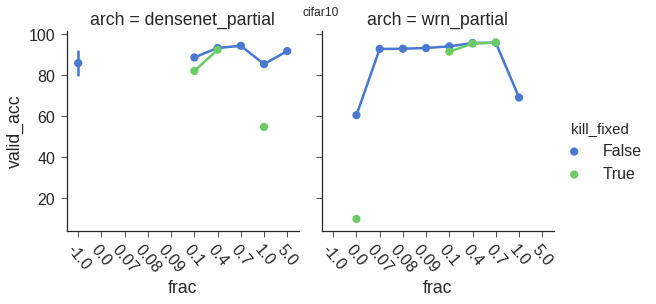

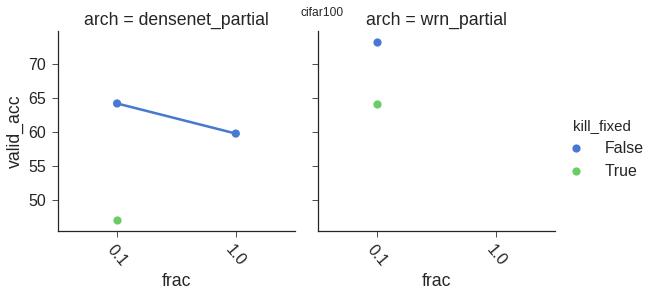

In [509]:
for z in ['cifar10','cifar100']:
    df = pd.DataFrame(ddd)
    df['frac'] = df['frac'].round(2)
    df=df[df.arch!='vgg19_partial']
    #df=df[df.arch=='wrn_partial']
    #df=df[df.fast_schedule==True]
    df=df[df.dataset==z]
    df=df[df.optimizer=='sgd']
    #df['abs_filters']=df.frac>=1
    df.sort_values('frac')
        
    #sns.factorplot(data=df,x='frac',y='valid_acc',hue='kill_fixed',col='arch')
    g=sns.factorplot(data=df,x='frac',y='valid_acc',hue='kill_fixed',col='arch')
    g.set_xticklabels(rotation=-50)

    suptitle(z)

In [504]:
df = pd.DataFrame(ddd)
df = df[df.frac==-1]
#df = df[df.dataset=='cifar10']
#df['valid_acc_max']=df.groupby(['train_only'])['valid_acc'].idxmax()

df.loc[df.groupby(['train_only','dataset'])["valid_acc"].idxmax()].sort_values(['train_only'])
#df.sort_values('valid_acc')


,active_params,all_accs,arch,dataset,fast_schedule,frac,kill_fixed,optimizer,total_params,train_only,valid_acc
1,194484,0 40.20 1 51.79 2 56.65 3 56.56 4 ...,densenet_partial,cifar10,False,-1.0,False,sgd,769162,block1,73.02
21,194484,0 6.88 1 9.20 2 10.72 3 12.32 4 ...,densenet_partial,cifar100,False,-1.0,False,sgd,800032,block1,22.89
9,1121312,0 27.77 1 37.05 2 43.45 3 46.79 4 ...,wrn_partial,cifar10,False,-1.0,False,sgd,5849050,block2,76.32
22,258996,0 7.79 1 10.30 2 12.28 3 15.51 4 ...,densenet_partial,cifar100,False,-1.0,False,sgd,800032,block2,28.00
3,291252,0 44.82 1 52.53 2 59.50 3 61.01 4 ...,densenet_partial,cifar10,False,-1.0,False,sgd,769162,block3,76.33
30,4463648,0 3.16 1 4.67 2 6.62 3 11.54 4 ...,wrn_partial,cifar100,False,-1.0,False,sgd,5872180,block3,32.35
0,24636,0 31.35 1 37.37 2 43.63 3 48.61 4 ...,densenet_partial,cifar10,False,-1.0,False,sgd,769162,conv1,64.76
20,24636,0 4.76 1 5.56 2 7.28 3 8.65 4 ...,densenet_partial,cifar100,False,-1.0,False,sgd,800032,conv1,15.08
4,27418,0 46.74 1 53.16 2 57.54 3 59.30 4 ...,densenet_partial,cifar10,False,-1.0,False,sgd,769162,fc,68.63
24,58288,0 12.66 1 16.34 2 19.99 3 21.82 4 ...,densenet_partial,cifar100,False,-1.0,False,sgd,800032,fc,33.43


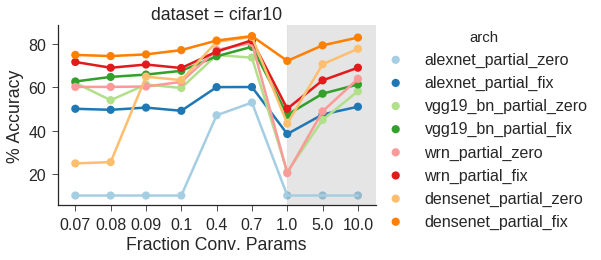

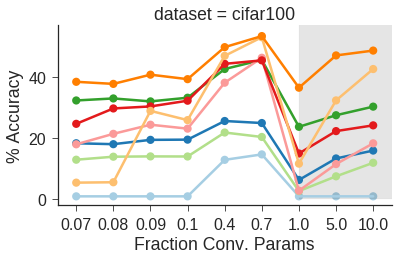

In [231]:
close()
df = pd.DataFrame(ddd)
df = df[df.arch!='vgg19_partial']
kf = df.kill_fixed
aa = df.arch
z = []
for a,b in zip(aa,kf):
    if b:
        z.append(a+'_zero')
    else:
        z.append(a+'_fix')
df['arch'] = z
import matplotlib.patches as patches

mm='Fraction Conv. Params'
acc_name = '% Accuracy'
df=df.rename(columns={'valid_acc':acc_name,'frac':mm})

df = df[::-1]
df[mm] = df[mm].round(2)


sns.set_style('ticks')
sns.set_context('paper',font_scale=2)
sns.set_palette('muted')
for z in ['cifar10','cifar100']:
    isFractional=(df[mm] > 0)# & (df[mm] < 1)
    isDataSet=(df['dataset'] == z)        
    kwargs = dict(data=df[isFractional & isDataSet],x=mm,y='% Accuracy',hue='arch',col='dataset',palette=sns.color_palette('Paired',n_colors=8, desat=1),
                      aspect=1.5)
    if z == 'cifar100':
        kwargs['legend']=None
    sns.factorplot(**kwargs)    
    ax = gca()    
    ax.plot(x=[5.9,5.9,],y=[0,100],color=[255,255,255],linewidth=10)
    #ax.scatter(5.9,100,marker='+')        
    #ax.plot([6-eps,6-eps],[10,100],color='k',linewidth=5,alpha=.1,linestyle='-')
    ax.add_patch(patches.Rectangle(xy=(6, 0), width=4, height=100,alpha=.1,color='k'))
    plt.savefig('/home/amir/publications/iclr_workshop/figures/fractional_{}.pdf'.format(z))